In [36]:
!pip install segmentation_models 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
%env SM_FRAMEWORK=tf.keras
import segmentation_models as sm
import keras 
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Input, Conv2D
from keras.models import Model
from google.colab import drive
from PIL import Image, ImageOps
from tensorflow.keras.utils import plot_model

env: SM_FRAMEWORK=tf.keras


In [38]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:
keras.backend.set_image_data_format('channels_last')

# Data prepairation

In [55]:
def reduce_size(path, size, padding):
  image = Image.open(path)
  image = ImageOps.grayscale(image)
  size = size - padding
  s = image.size
  if s[0] <= s[1]:
    image = image.resize((int(s[0]*(size/s[1])), size))
  else:
    image = image.resize((size, int(s[1]*(size/s[0]))))

  new_size = image.size
  delta_w = size - new_size[0] + padding
  delta_h = size - new_size[1] + padding
  padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
  new_img = np.array(ImageOps.expand(image, padding)).astype('float32')

  if len(new_img.shape) == 2:
    return new_img.reshape(256, 256, 1) / 255

  else:
     return new_img / 255

  

In [56]:
# Variable setting
image = []
mask = []
ratio = 0.7
resize = 256
padding = 10

In [57]:
image_root = '/content/drive/MyDrive/Dataset/1 - Raw/self_collected/'
mask_root = '/content/drive/MyDrive/Masked_image/Mask/'

print("Image:", len(os.listdir(image_root)))
print("Mask:", len(os.listdir(mask_root)))

Image: 401
Mask: 400


In [58]:
for path in os.listdir(mask_root):
  image.append(reduce_size(image_root + path, resize, padding))
  mask.append(reduce_size(mask_root + path, resize, padding))

In [59]:
image_root = '/content/drive/MyDrive/Dataset/1 - Raw/mc_ocr/'
mask_root = '/content/drive/MyDrive/Masked_image/Mask1/'

print("Image:", len(os.listdir(image_root)))
print("Mask:", len(os.listdir(mask_root)))

Image: 1155
Mask: 1155


In [60]:
for path in os.listdir(mask_root):
  image.append(reduce_size(image_root + path, resize, padding))
  mask.append(reduce_size(mask_root + path, resize, padding))

In [61]:
ids = np.arange(len(image))
np.random.shuffle(ids)
image = np.array(image)[ids]
mask = np.array(mask)[ids]

In [62]:
train_x = []
train_y = []
val_x = []
val_y = []

length = len(image)

train_x = image[:int(length*ratio)]
train_y = mask[:int(length*ratio)]

val_x = image[int(length*ratio):]
val_y = mask[int(length*ratio):]

In [63]:
image = []
mask = []

# Model 

In [69]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
train_x = np.stack(preprocess_input(train_x))
val_x = np.stack(preprocess_input(val_x))

# define model
N = train_x.shape[-1]
model = sm.Unet(BACKBONE, encoder_weights=None, input_shape=(None, None, N))

"""inp = Input(shape=(None, None, N))
l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
out = model(l1)

model = Model(inp, out, name=model.name)"""

model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

In [86]:
# fit model
# if you use data generator use model.fit_generator(...) instead of model.fit(...)
# more about `fit_generator` here: https://keras.io/models/sequential/#fit_generator
model.fit(
   x=train_x,
   y=train_y,
   batch_size=16,
   epochs=7,
   shuffle=True,
   validation_data=(val_x, val_y)
)

Epoch 1/7
68/68 [==============================] - 1200s 18s/step - loss: 0.0983 - iou_score: 0.9484 - val_loss: 0.1538 - val_iou_score: 0.9342
Epoch 2/7
68/68 [==============================] - 1195s 18s/step - loss: 0.0979 - iou_score: 0.9489 - val_loss: 0.5433 - val_iou_score: 0.8327
Epoch 3/7
68/68 [==============================] - 1204s 18s/step - loss: 0.1000 - iou_score: 0.9478 - val_loss: 0.1523 - val_iou_score: 0.9385
Epoch 4/7
68/68 [==============================] - 1200s 18s/step - loss: 0.0718 - iou_score: 0.9627 - val_loss: 0.2416 - val_iou_score: 0.9020
Epoch 5/7
32/68 [=============>................] - ETA: 9:21 - loss: 0.0848 - iou_score: 0.9574

KeyboardInterrupt: ignored

# Save model

In [93]:
model.save("/content/Model/Invoice_Segmentation_model")

# Load model

In [115]:
loaded_model = keras.models.load_model("/content/Model/Invoice_Segmentation_model.h5", compile=False)

In [116]:
test = loaded_model.predict(val_x[1].reshape((1, 256, 256, 1))).reshape((256, 256, 1))

1/1 [==============================] - 2s 2s/step


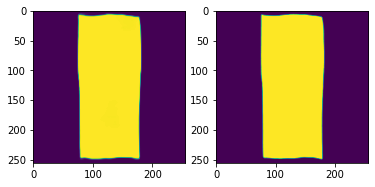

In [117]:
plt.subplot(121)
plt.imshow(test)

plt.subplot(122)
plt.imshow(val_y[1])